# Comparación de Modelos para Predicción de Stroke

Este notebook compara diferentes modelos para la predicción de stroke, incluyendo:

- Random Forest
- Gradient Boosting
- Red Neuronal (DNN)

El objetivo es evaluar las métricas de cada modelo y seleccionar el mejor para su uso en producción.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Para cargar el modelo DNN si está disponible
try:
    import tensorflow as tf
    from tensorflow.keras.models import load_model
    tf_available = True
except ImportError:
    print("TensorFlow no está disponible. No se podrá cargar el modelo DNN.")
    tf_available = False

# Configuración para reproducibilidad
np.random.seed(42)

## 1. Carga y Preprocesamiento de Datos

In [13]:
# Cargar el dataset
print("Cargando dataset...")
data_path = 'cleaned_dataset.csv'
data = pd.read_csv(data_path)

# Mostrar información del dataset
print(f"Forma del dataset: {data.shape}")
print("Primeras 5 filas:")
data.head()

Cargando dataset...
Forma del dataset: (5516, 17)
Primeras 5 filas:


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,3.0,0,0,0,0,95.12,18.0,0,0,0,0,1,1,0,0,0
1,1,58.0,1,0,1,1,87.96,39.2,0,0,1,0,0,0,0,1,0
2,0,8.0,0,0,0,1,110.89,17.6,0,0,1,0,0,1,0,0,0
3,0,70.0,0,0,1,0,69.04,35.9,0,0,1,0,0,0,1,0,0
4,0,52.0,0,0,1,1,77.59,17.7,0,0,1,0,0,0,1,0,0


Distribución de la variable objetivo (stroke):
stroke
0    4733
1     783
Name: count, dtype: int64
Porcentaje de la clase minoritaria (stroke=1): 14.20%


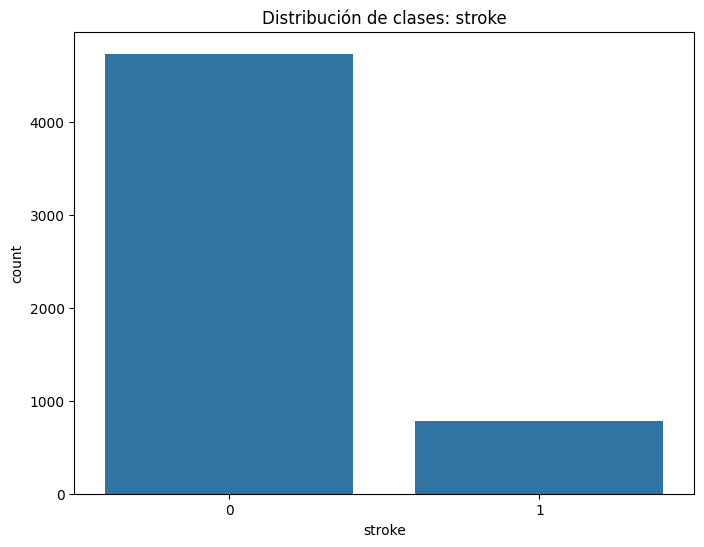

In [14]:
# Verificar distribución de la variable objetivo
print("Distribución de la variable objetivo (stroke):")
print(data['stroke'].value_counts())
print(f"Porcentaje de la clase minoritaria (stroke=1): {data['stroke'].mean() * 100:.2f}%")

# Visualizar la distribución de clases
plt.figure(figsize=(8, 6))
sns.countplot(x='stroke', data=data)
plt.title('Distribución de clases: stroke')
plt.show()

In [15]:
# Separar características y variable objetivo
X = data.drop('stroke', axis=1)
y = data['stroke']

# Imputación de valores faltantes usando Random Forest
print("Imputando valores faltantes con Random Forest...")
rf_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, random_state=42),
                             random_state=42, max_iter=10)
X_imputed = rf_imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE para balancear las clases (solo en el conjunto de entrenamiento)
print("Aplicando SMOTE para balancear las clases...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Verificar la nueva distribución de clases después de SMOTE
print("Distribución de clases después de SMOTE:")
unique, counts = np.unique(y_train_smote, return_counts=True)
for value, count in zip(unique, counts):
    print(f"Clase {value}: {count} muestras")

Imputando valores faltantes con Random Forest...
Aplicando SMOTE para balancear las clases...
Distribución de clases después de SMOTE:
Clase 0: 3786 muestras
Clase 1: 3786 muestras


## 2. Entrenamiento y Evaluación de Modelos

### 2.1 Random Forest

Entrenando modelo Random Forest...
Reporte de clasificación - Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       947
           1       0.35      0.69      0.47       157

    accuracy                           0.78      1104
   macro avg       0.65      0.74      0.66      1104
weighted avg       0.86      0.78      0.80      1104



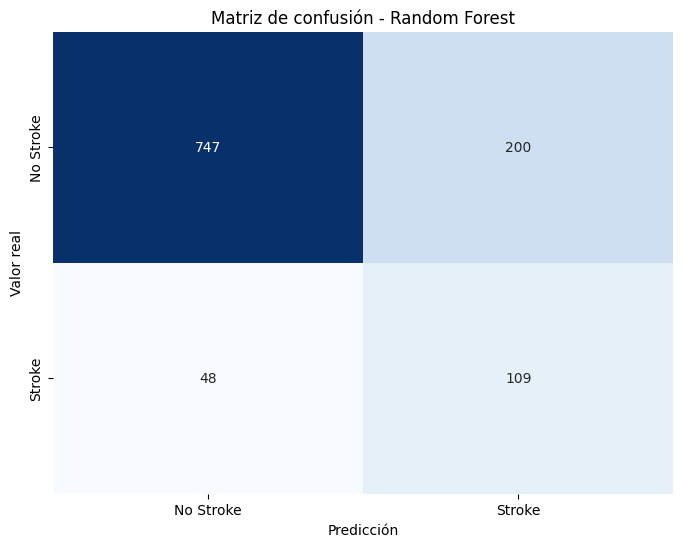

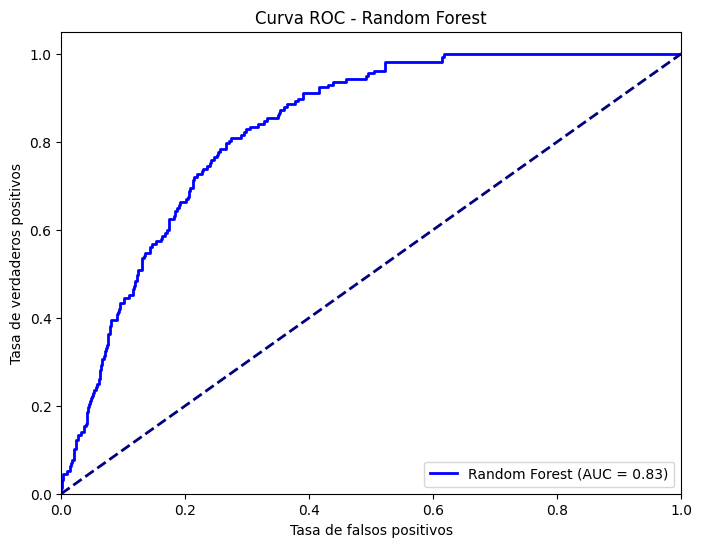

In [16]:
# Entrenar modelo Random Forest
print("Entrenando modelo Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Evaluar el modelo
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Reporte de clasificación - Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['No Stroke', 'Stroke'],
           yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión - Random Forest')
plt.show()

# Curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()

### 2.2 Gradient Boosting

Entrenando modelo Gradient Boosting...
Reporte de clasificación - Gradient Boosting:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       947
           1       0.39      0.59      0.47       157

    accuracy                           0.81      1104
   macro avg       0.66      0.72      0.68      1104
weighted avg       0.85      0.81      0.83      1104



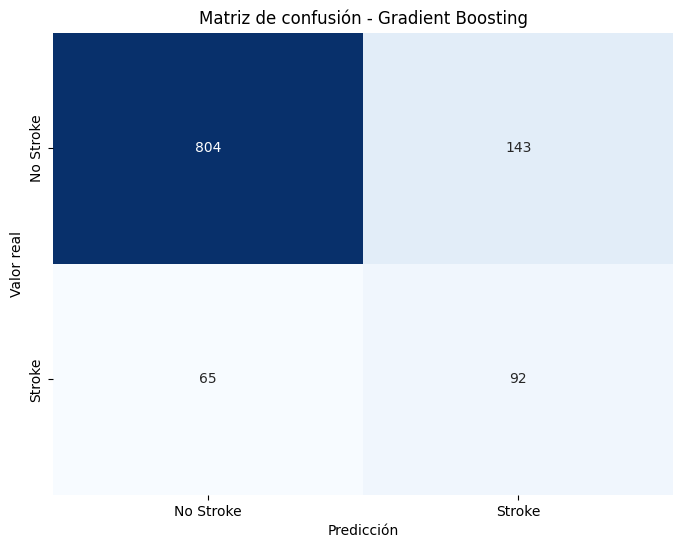

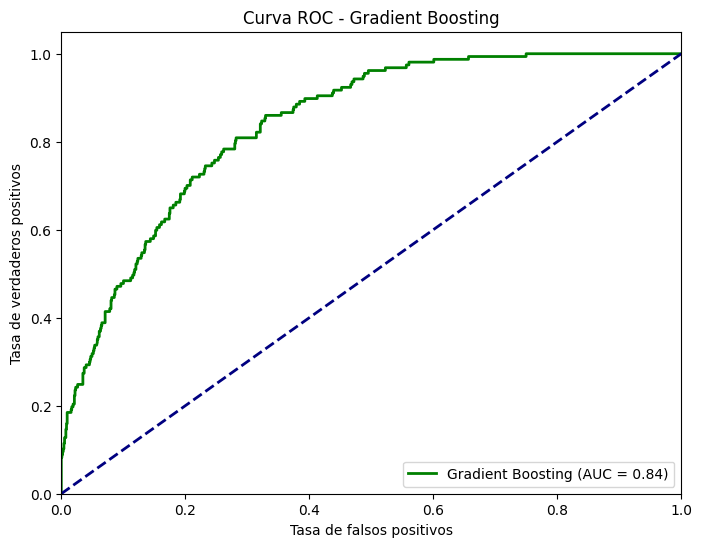

In [17]:
# Entrenar modelo Gradient Boosting
print("Entrenando modelo Gradient Boosting...")
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_smote, y_train_smote)

# Evaluar el modelo
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

print("Reporte de clasificación - Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))

# Matriz de confusión
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['No Stroke', 'Stroke'],
           yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión - Gradient Boosting')
plt.show()

# Curva ROC
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='green', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

### 2.3 Red Neuronal (DNN)

Cargando modelo DNN...

35/35 [==============================] - 0s 669us/step
Reporte de clasificación - DNN:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       947
           1       0.36      0.59      0.45       157

    accuracy                           0.79      1104
   macro avg       0.64      0.71      0.66      1104
weighted avg       0.84      0.79      0.81      1104



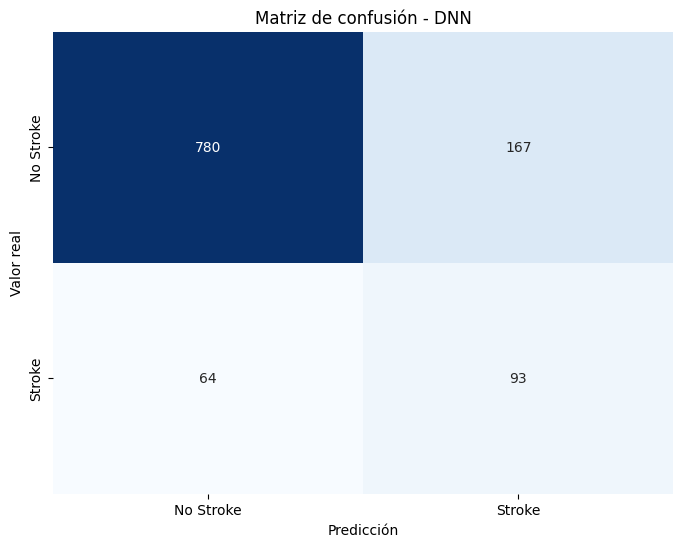

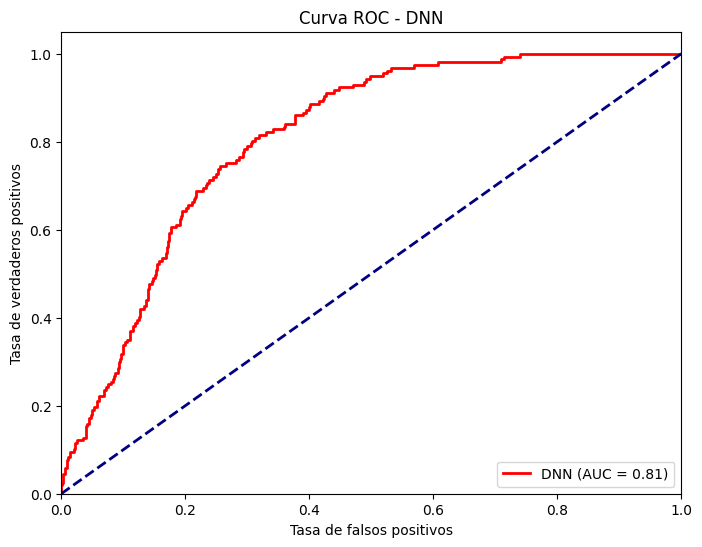

In [18]:
# Cargar el modelo DNN si está disponible
if tf_available:
    try:
        dnn_model_path = 'dnn_stroke_prediction_model.h5'
        if os.path.exists(dnn_model_path):
            print("Cargando modelo DNN...")
            dnn_model = load_model(dnn_model_path)
            
            # Evaluar el modelo
            y_pred_proba_dnn = dnn_model.predict(X_test_scaled)
            y_pred_dnn = (y_pred_proba_dnn > 0.5).astype(int)
            
            print("Reporte de clasificación - DNN:")
            print(classification_report(y_test, y_pred_dnn))
            
            # Matriz de confusión
            cm_dnn = confusion_matrix(y_test, y_pred_dnn)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Blues', cbar=False,
                       xticklabels=['No Stroke', 'Stroke'],
                       yticklabels=['No Stroke', 'Stroke'])
            plt.xlabel('Predicción')
            plt.ylabel('Valor real')
            plt.title('Matriz de confusión - DNN')
            plt.show()
            
            # Curva ROC
            fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_pred_proba_dnn)
            roc_auc_dnn = auc(fpr_dnn, tpr_dnn)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr_dnn, tpr_dnn, color='red', lw=2, label=f'DNN (AUC = {roc_auc_dnn:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Tasa de falsos positivos')
            plt.ylabel('Tasa de verdaderos positivos')
            plt.title('Curva ROC - DNN')
            plt.legend(loc='lower right')
            plt.show()
        else:
            print(f"No se encontró el modelo DNN en {dnn_model_path}. Ejecute primero el notebook dnn_stroke_prediction_model.ipynb")
    except Exception as e:
        print(f"Error al cargar el modelo DNN: {e}")
else:
    print("TensorFlow no está disponible. No se puede cargar el modelo DNN.")

## 3. Comparación de Modelos

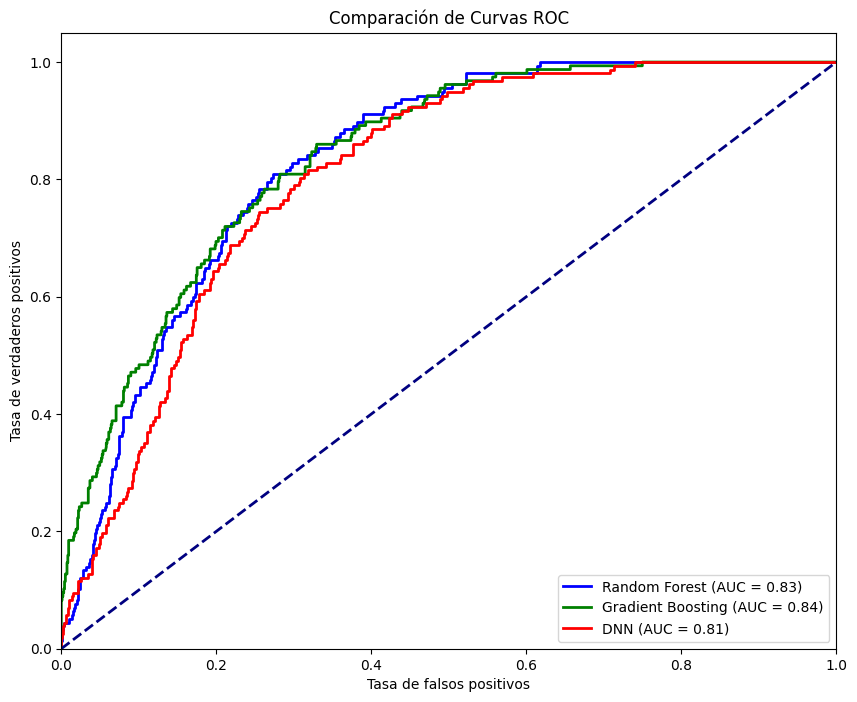

In [19]:
# Comparar curvas ROC de todos los modelos
plt.figure(figsize=(10, 8))

# Random Forest
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Gradient Boosting
plt.plot(fpr_gb, tpr_gb, color='green', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')

# DNN (si está disponible)
if tf_available and 'roc_auc_dnn' in locals():
    plt.plot(fpr_dnn, tpr_dnn, color='red', lw=2, label=f'DNN (AUC = {roc_auc_dnn:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Comparación de Curvas ROC')
plt.legend(loc='lower right')
plt.show()

In [20]:
# Crear tabla de comparación de métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    'Modelo': ['Random Forest', 'Gradient Boosting'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_gb)],
    'Precision (Clase 1)': [precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_gb)],
    'Recall (Clase 1)': [recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_gb)],
    'F1-Score (Clase 1)': [f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_gb)],
    'AUC': [roc_auc_rf, roc_auc_gb]
}

# Añadir DNN si está disponible
if tf_available and 'y_pred_dnn' in locals():
    metrics['Modelo'].append('DNN')
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred_dnn))
    metrics['Precision (Clase 1)'].append(precision_score(y_test, y_pred_dnn))
    metrics['Recall (Clase 1)'].append(recall_score(y_test, y_pred_dnn))
    metrics['F1-Score (Clase 1)'].append(f1_score(y_test, y_pred_dnn))
    metrics['AUC'].append(roc_auc_dnn)

metrics_df = pd.DataFrame(metrics)
metrics_df

,Modelo,Accuracy,Precision (Clase 1),Recall (Clase 1),F1-Score (Clase 1),AUC
0,Random Forest,0.775362,0.352751,0.694268,0.467811,0.831893
1,Gradient Boosting,0.811594,0.391489,0.585987,0.469388,0.839840
2,DNN,0.790761,0.357692,0.592357,0.446043,0.807700


## 4. Guardar el Mejor Modelo

In [23]:
# Determinar el mejor modelo basado en F1-Score para la clase positiva
best_model_name = metrics_df.loc[metrics_df['F1-Score (Clase 1)'].idxmax(), 'Modelo']
print(f"El mejor modelo basado en F1-Score para la clase positiva es: {best_model_name}")

# Guardar el mejor modelo
if best_model_name == 'Random Forest':
    best_model = rf_model
    model_filename = 'best_model_rf.pkl'
elif best_model_name == 'Gradient Boosting':
    best_model = gb_model
    model_filename = 'best_model_gb.pkl'
elif best_model_name == 'DNN' and tf_available and 'dnn_model' in locals():
    print("El mejor modelo es DNN, ya guardado como 'dnn_stroke_prediction_model.h5'")
    model_filename = None
else:
    print("No se pudo determinar el mejor modelo.")
    model_filename = None

if model_filename:
    with open(model_filename, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Mejor modelo guardado como: {model_filename}")
    
    # Guardar también el scaler y el imputador
    with open('best_model_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("Scaler guardado como: best_model_scaler.pkl")
    
    with open('best_model_imputer.pkl', 'wb') as f:
        pickle.dump(rf_imputer, f)
    print("Imputador guardado como: best_model_imputer.pkl")

El mejor modelo basado en F1-Score para la clase positiva es: Gradient Boosting
Mejor modelo guardado como: best_model_gb.pkl
Scaler guardado como: best_model_scaler.pkl
Imputador guardado como: best_model_imputer.pkl


## 5. Función para Realizar Predicciones con el Mejor Modelo

In [24]:
def predict_stroke_best_model(data, threshold=0.5):
    """
    Realiza predicciones utilizando el mejor modelo.
    
    Args:
        data: DataFrame con las características del paciente
        threshold: Umbral de decisión para la clasificación (default: 0.5)
        
    Returns:
        prediction: Predicción binaria (0: No stroke, 1: Stroke)
        probability: Probabilidad de stroke
    """
    # Imputar valores faltantes
    data_imputed = rf_imputer.transform(data)
    
    # Escalar características
    data_scaled = scaler.transform(data_imputed)
    
    # Realizar predicción con el mejor modelo
    if best_model_name == 'DNN' and tf_available and 'dnn_model' in locals():
        probability = dnn_model.predict(data_scaled)[0][0]
    else:
        probability = best_model.predict_proba(data_scaled)[0, 1]
    
    prediction = 1 if probability > threshold else 0
    
    return prediction, probability

In [25]:
# Ejemplo de uso de la función de predicción
print("Ejemplo de predicción con el mejor modelo:")
sample = X_test.iloc[0:1]
prediction, probability = predict_stroke_best_model(sample)
print(f"Características del paciente:{sample}")
print(f"Predicción: {'Stroke' if prediction == 1 else 'No Stroke'}")
print(f"Probabilidad de stroke: {probability:.4f}")
print(f"Valor real: {'Stroke' if y_test.iloc[0] == 1 else 'No Stroke'}")

print("Proceso completado.")

Ejemplo de predicción con el mejor modelo:
Características del paciente:      gender   age  hypertension  heart_disease  ever_married  Residence_type  \
2204     1.0  10.0           0.0            0.0           0.0             1.0   

      avg_glucose_level   bmi  work_type_Govt_job  work_type_Private  \
2204              76.92  15.8                 0.0                0.0   

      work_type_Self-employed  work_type_children  smoking_status_Unknown  \
2204                      0.0                 1.0                     1.0   

      smoking_status_formerly smoked  smoking_status_never smoked  \
2204                             0.0                          0.0   

      smoking_status_smokes  
2204                    0.0  
Predicción: No Stroke
Probabilidad de stroke: 0.0084
Valor real: No Stroke
Proceso completado.


e:\My documents\Cursos\Bootcamp IA\Proyecto-IX-DS2\tf_env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
